### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'it_salary',
    'source': 'kaggle', # ['kaggle', 'local', 'openml', 'hf']
    'remote_path': 'parulpandey/2020-it-salary-survey-for-eu-region',
    'files': ['IT%20Salary%20Survey%20EU%20%202020.csv'],
    'rename_files': ['IT_salary_eu_data.csv'],
    'task': 'reg', # ['reg', 'clf']
    'target': 'Yearly brutto salary (without bonus and stocks) in EUR',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/it_salary.
Downloaded it_salary dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/it_salary


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:

dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/it_salary/IT_salary_eu_data.csv


,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,Annual bonus+stocks one year ago. Only answer if staying in same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?,"Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week","Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR"
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,75000.0,10000,30,Full-time employee,Unlimited contract,English,51-100,Product,No,NaN,NaN
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,82000.0,5000,28,Full-time employee,Unlimited contract,English,101-1000,Product,No,NaN,NaN
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,100000.0,100000,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,Yes,NaN,NaN


In [6]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []
missing_ratio_threshold = 0.5 # TODO the threshold can be changed

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=missing_ratio_threshold)   
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index(['Annual bonus+stocks one year ago. Only answer if staying in same country',
       'Have you been forced to have a shorter working week (Kurzarbeit)? If yes, how many hours per week',
       'Have you received additional monetary support from your employer due to Work From Home? If yes, how much in 2020 in EUR'],
      dtype='object')
Dataframe shape before/afrer cleaning: (1253, 23) / (1253, 20)


In [7]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Timestamp']

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")

dataset_files_cleaned[0].head(n=3)

Dataframe shape before/afrer by-hand cleaning: (1253, 20) / (1253, 19)


,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,75000.0,30,Full-time employee,Unlimited contract,English,51-100,Product,No
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,82000.0,28,Full-time employee,Unlimited contract,English,101-1000,Product,No
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,100000.0,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,Yes


In [8]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)
dataset_files_by_hand_cleaned = []

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    # TODO: add custom data cleaning here
    # e.g. remove columns with too many unique values
    print(f"Dataframe shape after custom clearning: {df_file.shape}")

    dataset_files_by_hand_cleaned.append(df_file)

# reset the dataframe list to the version before custom cleaning -> next cells work wuth dataset_files_by_hand_cleaned
dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (1253, 19)
Dataframe shape after custom clearning: (1253, 19)


### Now it is time to visualize our changes

In [9]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?
0,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,75000.0,30,Full-time employee,Unlimited contract,English,51-100,Product,No
1,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,82000.0,28,Full-time employee,Unlimited contract,English,101-1000,Product,No
2,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,100000.0,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,Yes


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [10]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    # umerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)



Threshold for categorical vs textual: 50
Numerical columns (6): ['Total years of experience', 'Yearly brutto salary (without bonus and stocks) in EUR', 'Yearly bonus + stocks in EUR', 'Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country', 'Number of vacation days', 'Company size']
Categorical columns (7): ['Age', 'Gender', 'Seniority level', 'Employment status', 'Сontract duration', 'Main language at work', 'Have you lost your job due to the coronavirus outbreak?']
Textual columns (6): ['City', 'Position ', 'Years of experience in Germany', 'Your main technology / programming language', 'Other technologies/programming languages you use often', 'Company type']


Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [11]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)
summary_df.loc[summary_df['Column Name'] == 'Company size', 'Type'] = 'categorical'
num_categories = df_file['Company size'].nunique(dropna=True)
summary_df.loc[summary_df['Column Name'] == 'Company size', '# Categories'] = int(num_categories)


display(summary_df)  # Or print(summary_df)


,Column Name,Example Value,Type,# Categories
0,Age,26.0,categorical,40
1,Gender,Male,categorical,3
2,City,Munich,textual,119
3,Position,Software Engineer,textual,148
4,Total years of experience,5,numerical,~ 48 ~
5,Years of experience in Germany,3,textual,53
6,Seniority level,Senior,categorical,24
7,Your main technology / programming language,TypeScript,textual,256
8,Other technologies/programming languages you u...,"Kotlin, Javascript / Typescript",textual,562
9,Yearly brutto salary (without bonus and stocks...,80000.0,numerical,~ 201 ~


### Saving the processed data and loading it back up

In [12]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


File /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/it_salary/it_salary_processed.pkl already exists. Skipping save.


In [13]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))


it_salary

=== IT_SALARY ===
Loaded config keys: ['dataset_name', 'source', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Timestamp,numerical,~ 1248 ~
1,Age,categorical,40
2,Gender,categorical,3
3,City,textual,119
4,Position,textual,148
5,Total years of experience,numerical,~ 48 ~
6,Years of experience in Germany,textual,53
7,Seniority level,categorical,24
8,Your main technology / programming language,textual,256
9,Other technologies/programming languages you u...,textual,562


Column Name,Timestamp,Age,Gender,City,Position,Total years of experience,Years of experience in Germany,Seniority level,Your main technology / programming language,Other technologies/programming languages you use often,Yearly brutto salary (without bonus and stocks) in EUR,Yearly bonus + stocks in EUR,Annual brutto salary (without bonus and stocks) one year ago. Only answer if staying in the same country,Number of vacation days,Employment status,Сontract duration,Main language at work,Company size,Company type,Have you lost your job due to the coronavirus outbreak?
0,24/11/2020 11:14:15,26.0,Male,Munich,Software Engineer,5,3,Senior,TypeScript,"Kotlin, Javascript / Typescript",80000.0,5000,75000.0,30,Full-time employee,Unlimited contract,English,51-100,Product,No
1,24/11/2020 11:14:16,26.0,Male,Berlin,Backend Developer,7,4,Senior,Ruby,NaN,80000.0,NaN,82000.0,28,Full-time employee,Unlimited contract,English,101-1000,Product,No
2,24/11/2020 11:14:21,29.0,Male,Berlin,Software Engineer,12,6,Lead,Javascript / Typescript,"Javascript / Typescript, Docker",120000.0,120000,100000.0,30,Self-employed (freelancer),Temporary contract,English,101-1000,Product,Yes


### Bonus insights (Regression)

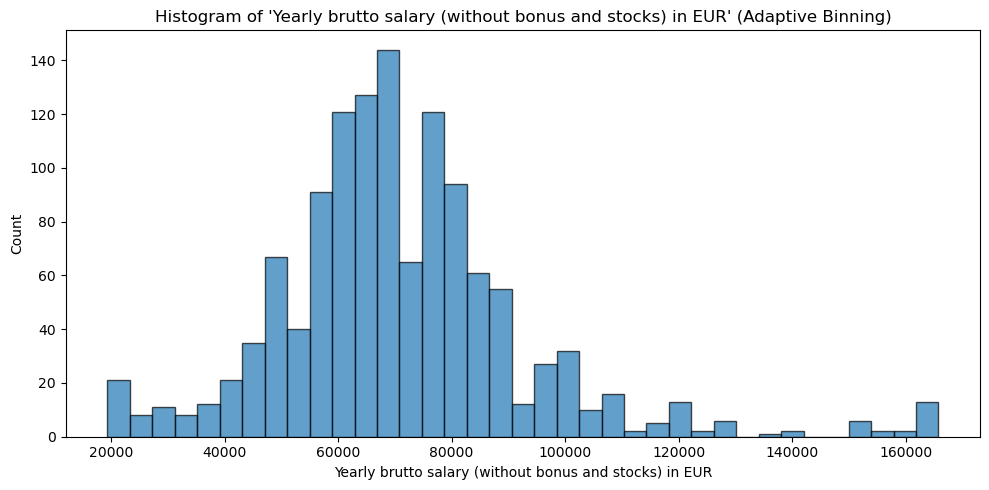

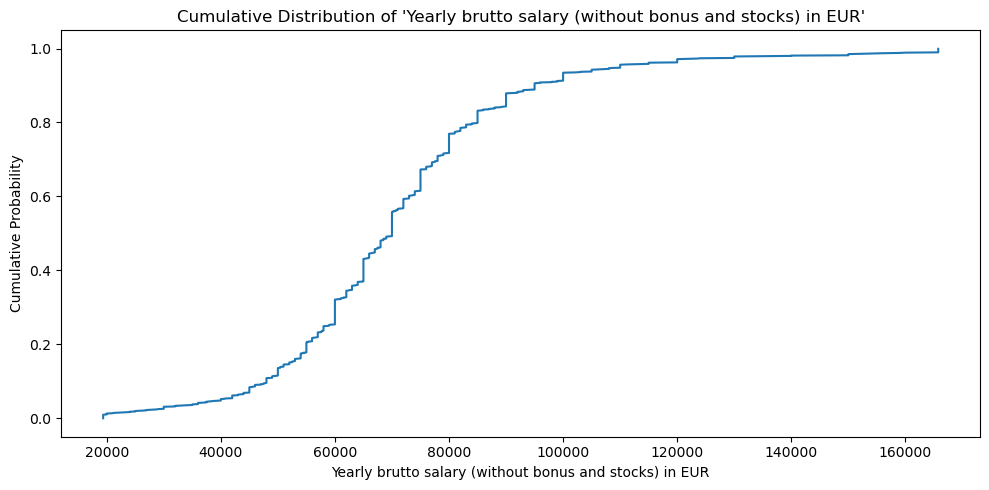

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Clean + numeric target
target_series = pd.to_numeric(loaded_df[dataset_config['target']], errors='coerce').dropna()

# Optional: clip outliers for better visuals
target_series = target_series.clip(lower=target_series.quantile(0.01),
                                   upper=target_series.quantile(0.99))

# Freedman–Diaconis binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = max(10, min(100, int((target_series.max() - target_series.min()) / bin_width)))

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# CDF
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()
